# To use this notebook, have data of the following form in a CSV file
![data format example](Ben_CSV_example.jpg)


# Contents

#### 1. Prepare for analysis (import packages and set working directory)
#### 2. Read in, tidy, and explore the data
#### 3. Generate speed trace
#### 4. Generate OffFood/OnFood comparison bar plots (including BSR)
#### 5. Generate phenotype heatmap

# 1 - Prepare for analysis

## 1.1 - Import required packages

In [1]:
import os  # <- package used to work with system filepaths
import pandas as pd  # <- package used to import and organize data
import numpy as np  # <- package used to import and organize data
import math
import seaborn as sns  # <- package used to plot graphs
from matplotlib import pyplot as plt  # <- another package used to plot graphs
from itertools import cycle  # <- package used to iterate down rows
from ipywidgets import widgets  # <- widget tool to generate button
from IPython.display import display  # <- displays button
from tkinter import Tk, filedialog  # <- Tkinter is a GUI package
from tqdm.notebook import tqdm
import pingouin as pg
from pingouin import ttest
from scipy.stats import ttest_ind
import sklearn
pd.set_option('display.max_columns', 50)
print("done step 1")

done step 1


## 1.2 - Set working directory to where the CSV file with experiment data is

In [2]:
os.getcwd()
os.chdir('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data')

# 2 - Read in, tidy, and explore the data

## 2.1 - Read in the data, check its size and format

In [3]:
df1 = pd.read_csv('baseline_output_02Oct2023.csv')
df2 = pd.read_csv('baseline_output_09Oct2023.csv')
df3 = pd.read_csv('baseline_output_23Oct2023.csv')
df4 = pd.read_csv('baseline_output_13Nov2023.csv')
df5 = pd.read_csv('baseline_output_28Nov2023.csv')
df6 = pd.read_csv('baseline_output_06Jan2024.csv')
df7 = pd.read_csv('baseline_output_14Jan2024.csv')
df8 = pd.read_csv('baseline_output_22Jan2024.csv')
df9 = pd.read_csv('baseline_output_29Jan2024.csv')
df10 = pd.read_csv('baseline_output_08Feb2024.csv')

# List of DataFrames to append
dfs_to_append = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

# Concatenate the DataFrames
TotalConcatenated = pd.concat(dfs_to_append, ignore_index=True)

# TotalConcatenated = pd.read_csv('baseline_output.csv')

print(TotalConcatenated.shape)
print(TotalConcatenated.head())
print(TotalConcatenated.tail())

(4992498, 20)
   Unnamed: 0  time_bin  worm      time     speed          x          y  \
0           0       4.0   381  3.875333  0.199433  27.866700  31.581700   
1           1       4.0   424  3.959000  0.215800  29.280800  33.929100   
2           2       4.0  1230  3.646400  0.282660  23.147860  26.087340   
3           3       4.0  1298  3.526000  0.365729  18.305986  23.741629   
4           4       5.0   309  4.903500  0.265500  27.393750  29.994300   

   angularspeed  pathlength       kink  bias      curve  dir      crab  \
0      5.233333    0.030333  34.000000   1.0  39.433333  0.0  0.015700   
1      3.900000    0.017000  46.300000   1.0  35.300000  0.0  0.042900   
2     10.040000    0.097600  34.520000   1.0  30.720000  0.0  0.036280   
3     17.428571    0.170429  36.857143   1.0  34.785714  0.0  0.032114   
4     22.950000    0.035500  15.250000   1.0  28.300000  0.0  0.025750   

    length   midline     width  morphwidth      area   Strain  
0  0.87930  0.977933  0.16

## 2.2 - Get list of strains in the data set

In [4]:
TotalConcatenated_strains = TotalConcatenated.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)
TotalConcatenated_strains = TotalConcatenated_strains.dropna()
TotalConcatenated_strains = TotalConcatenated_strains.Genotype.unique()

# print(TotalConcatenated_strains.head())
# print(TotalConcatenated_strains.tail())

print(TotalConcatenated_strains)

all_strains = pd.DataFrame(TotalConcatenated_strains, columns = ['Genotype'])
print(all_strains)

['N2' 'cat-2(e1112)' 'catp-7(tm4438)' 'catp-7(tm8556)' 'cpr-4(ok3413)'
 'cpr-5(ok2344)' 'cpr-6(tm12210)' 'cpr-8(ok2956)' 'djr-1.1(tm918)'
 'djr-1.2(tm817)' 'djr-1.2(tm951)' 'exp-2(sa26ad1426)' 'kvs-5(tm6152)'
 'lfe-2(sy326)' 'mbr-1(qa5901)' 'mbr-1(tm1235)' 'ncs-4(tm4409)'
 'rme-8(b1023)' 'sipa-1(tm11702)']
             Genotype
0                  N2
1        cat-2(e1112)
2      catp-7(tm4438)
3      catp-7(tm8556)
4       cpr-4(ok3413)
5       cpr-5(ok2344)
6      cpr-6(tm12210)
7       cpr-8(ok2956)
8      djr-1.1(tm918)
9      djr-1.2(tm817)
10     djr-1.2(tm951)
11  exp-2(sa26ad1426)
12      kvs-5(tm6152)
13       lfe-2(sy326)
14      mbr-1(qa5901)
15      mbr-1(tm1235)
16      ncs-4(tm4409)
17       rme-8(b1023)
18    sipa-1(tm11702)


C:\Users\chris\AppData\Local\Temp\ipykernel_49340\2338513971.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)


## 2.3 - Determine the range for which you want to analyze data

In [5]:
start = 100  # <----- set the start time of the range
point = 400  # <----- set the end time of your range

TotalConcatenated_chunked0 = TotalConcatenated[TotalConcatenated["time"] >= start]
TotalConcatenated_chunked = TotalConcatenated_chunked0[TotalConcatenated_chunked0["time"] <= point]
print(TotalConcatenated_chunked.head())

       Unnamed: 0  time_bin  worm        time     speed          x          y  \
24560       24560     101.0     5  100.486917  0.045883  24.611192  25.134608   
24561       24561     101.0     9  100.486917  0.066300  16.949775  35.667133   
24562       24562     101.0    10  100.486917  0.048625  38.198275  33.481442   
24563       24563     101.0    11  100.486917  0.051950  15.785642  42.590175   
24564       24564     101.0    13  100.486917  0.051442  28.184600  44.454567   

       angularspeed  pathlength       kink  bias      curve  dir      crab  \
24560      2.416667    0.325083  56.950000   1.0  26.683333  0.0  0.006967   
24561     10.208333    3.951167  98.658333   1.0  36.050000  0.0  0.011908   
24562      1.175000    2.136917  32.741667   1.0  29.183333  0.0  0.004075   
24563      1.991667    4.072417  26.358333   1.0  23.166667  0.0  0.003783   
24564      2.991667    6.262167  84.608333   1.0  33.025000  0.0  0.003767   

         length   midline     width  morphwi

## 2.4 - Find average measures for each worm (across duration of specified range), split 'Strain' column into two

Ex: 'N2_OnFood' becomes 'N2' & 'OnFood'

In [6]:
TotalConcatenated_mean = TotalConcatenated_chunked.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_mean[['Genotype', 'Treatment']] = TotalConcatenated_mean['Strain'].str.split('_', expand = True)
TotalConcatenated_mean[['Gene','Allele']]=TotalConcatenated_mean['Genotype'].str.split('(',expand=True)
TotalConcatenated_mean['Allele']=TotalConcatenated_mean['Allele'].str[:-1]
print(TotalConcatenated_mean.groupby(['Gene'], as_index = False).mean())
# # TotalConcatenated_mean['Gene']=TotalConcatenated['Gene'].fill_na('N2')
print(TotalConcatenated_mean)
print(TotalConcatenated_mean.Gene.unique())

# SELECT ONLY NECESSARY COLUMNS
# TotalConcatenated_worm_avg_speed = TotalConcatenated_mean[['Gene','Genotype', 'Treatment', 'Strain', 'speed']]
TotalConcatenated_worm_avg_speed = TotalConcatenated_mean[['Gene','Genotype', 'Treatment', 'Strain', 'speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']]
print(TotalConcatenated_worm_avg_speed)
By_gene_avg_speed=TotalConcatenated_mean[['Gene','Treatment', 'speed']]

       Gene        worm    Unnamed: 0    time_bin        time     speed  \
0        N2  936.606757  49369.108700  246.015830  245.516084  0.152482   
1     cat-2  831.160880  37560.245747  252.308945  251.809106  0.195498   
2    catp-7  446.383384  36487.030634  238.817391  238.316227  0.130829   
3     cpr-4  505.576691  32772.271900  250.781567  250.281056  0.097921   
4     cpr-5  648.010762  41184.102798  249.323234  248.822987  0.111420   
5     cpr-6  546.285425  38162.472596  230.464238  229.961803  0.141625   
6     cpr-8  114.158076  12476.412927  247.620362  247.120571  0.073973   
7   djr-1.1  423.069109  33424.036227  238.365717  237.866602  0.117019   
8   djr-1.2  694.517155  53702.429113  236.097661  235.596931  0.132476   
9     exp-2  536.882197  39598.443485  236.802466  236.302000  0.119395   
10    kvs-5  410.664158  36997.232086  227.830668  227.328094  0.101076   
11    lfe-2  644.827873  51472.674219  232.688205  232.187628  0.123544   
12    mbr-1  368.227606  

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\113953120.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(TotalConcatenated_mean.groupby(['Gene'], as_index = False).mean())


## 2.5 - Find average speed measures for each genotype and treatment (across duration of specified range)

In [7]:
TotalConcatenated_avg_speed = TotalConcatenated_worm_avg_speed.groupby(['Gene','Strain', 'Treatment', 'Genotype'], as_index = False).mean()
print(TotalConcatenated_avg_speed)
# print(TotalConcatenated_avg_speed['speed'][1])

ByGene_avg_speed = By_gene_avg_speed.groupby(['Gene','Treatment'], as_index = False).mean()
print(ByGene_avg_speed)

       Gene                    Strain Treatment           Genotype     speed  \
0        N2                   N2_Food      Food                 N2  0.114303   
1        N2                 N2_NoFood    NoFood                 N2  0.183959   
2     cat-2         cat-2(e1112)_Food      Food       cat-2(e1112)  0.190769   
3     cat-2       cat-2(e1112)_NoFood    NoFood       cat-2(e1112)  0.201690   
4    catp-7       catp-7(tm4438)_Food      Food     catp-7(tm4438)  0.059566   
5    catp-7     catp-7(tm4438)_NoFood    NoFood     catp-7(tm4438)  0.169173   
6    catp-7       catp-7(tm8556)_Food      Food     catp-7(tm8556)  0.066759   
7    catp-7     catp-7(tm8556)_NoFood    NoFood     catp-7(tm8556)  0.155092   
8     cpr-4        cpr-4(ok3413)_Food      Food      cpr-4(ok3413)  0.066865   
9     cpr-4      cpr-4(ok3413)_NoFood    NoFood      cpr-4(ok3413)  0.117684   
10    cpr-5        cpr-5(ok2344)_Food      Food      cpr-5(ok2344)  0.075383   
11    cpr-5      cpr-5(ok2344)_NoFood   

## 2.6 - Generate dataframe containing only data for N2 and CB1112 for use in speed trace

In [8]:
# print(TotalConcatenated_avg_speed.Allele.unique())
print(TotalConcatenated_avg_speed.Strain.unique())

['N2_Food' 'N2_NoFood' 'cat-2(e1112)_Food' 'cat-2(e1112)_NoFood'
 'catp-7(tm4438)_Food' 'catp-7(tm4438)_NoFood' 'catp-7(tm8556)_Food'
 'catp-7(tm8556)_NoFood' 'cpr-4(ok3413)_Food' 'cpr-4(ok3413)_NoFood'
 'cpr-5(ok2344)_Food' 'cpr-5(ok2344)_NoFood' 'cpr-6(tm12210)_Food'
 'cpr-6(tm12210)_NoFood' 'cpr-8(ok2956)_Food' 'cpr-8(ok2956)_NoFood'
 'djr-1.1(tm918)_Food' 'djr-1.1(tm918)_NoFood' 'djr-1.2(tm817)_Food'
 'djr-1.2(tm817)_NoFood' 'djr-1.2(tm951)_Food' 'djr-1.2(tm951)_NoFood'
 'exp-2(sa26ad1426)_Food' 'exp-2(sa26ad1426)_NoFood' 'kvs-5(tm6152)_Food'
 'kvs-5(tm6152)_NoFood' 'lfe-2(sy326)_Food' 'lfe-2(sy326)_NoFood'
 'mbr-1(qa5901)_Food' 'mbr-1(qa5901)_NoFood' 'mbr-1(tm1235)_Food'
 'mbr-1(tm1235)_NoFood' 'ncs-4(tm4409)_Food' 'ncs-4(tm4409)_NoFood'
 'rme-8(b1023)_Food' 'rme-8(b1023)_NoFood' 'sipa-1(tm11702)_Food'
 'sipa-1(tm11702)_NoFood']


In [9]:
list=['N2', 'cat-2']
print(TotalConcatenated_avg_speed[TotalConcatenated_avg_speed['Gene'].isin(list)])

    Gene               Strain Treatment      Genotype     speed  angularspeed  \
0     N2              N2_Food      Food            N2  0.114303      7.674082   
1     N2            N2_NoFood    NoFood            N2  0.183959     15.092171   
2  cat-2    cat-2(e1112)_Food      Food  cat-2(e1112)  0.190769     14.697636   
3  cat-2  cat-2(e1112)_NoFood    NoFood  cat-2(e1112)  0.201690     17.907270   

       bias      curve      crab       kink  
0  0.748695  33.855474  0.013570  50.568814  
1  0.560944  36.700992  0.023351  56.431773  
2  0.694872  34.399584  0.023869  53.138344  
3  0.511819  36.482369  0.027049  59.409818  


In [10]:
# N2_cat2 = ['N2_OffFood', 'N2_OnFood', 'cat-2(e1112)_OffFood', 'cat-2(e1112)_OnFood']
N2_cat2 = ['N2_NoFood', 'N2_Food', 'cat-2(e1112)_NoFood', 'cat-2(e1112)_Food']
TotalN2cat2 = TotalConcatenated[TotalConcatenated['Strain'].isin(N2_cat2)]

print(TotalN2cat2)

         Unnamed: 0  time_bin  worm        time     speed          x  \
0                 0       4.0   381    3.875333  0.199433  27.866700   
1                 1       4.0   424    3.959000  0.215800  29.280800   
2                 2       4.0  1230    3.646400  0.282660  23.147860   
3                 3       4.0  1298    3.526000  0.365729  18.305986   
4                 4       5.0   309    4.903500  0.265500  27.393750   
...             ...       ...   ...         ...       ...        ...   
4769710       74397     420.0  1061  419.492462  0.178831  42.237208   
4769711       74398     420.0  1071  419.492462  0.238923  31.932269   
4769712       74399     420.0  1127  419.491826  0.177783   5.601565   
4769713       74400     420.0  1176  419.461857  0.263114  33.887724   
4769714       74401     420.0  1208  419.491826  0.265165  42.797470   

                 y  angularspeed  pathlength       kink      bias      curve  \
0        31.581700      5.233333    0.030333  34.000000

# 3 - Generate speed trace

<Figure size 640x480 with 0 Axes>

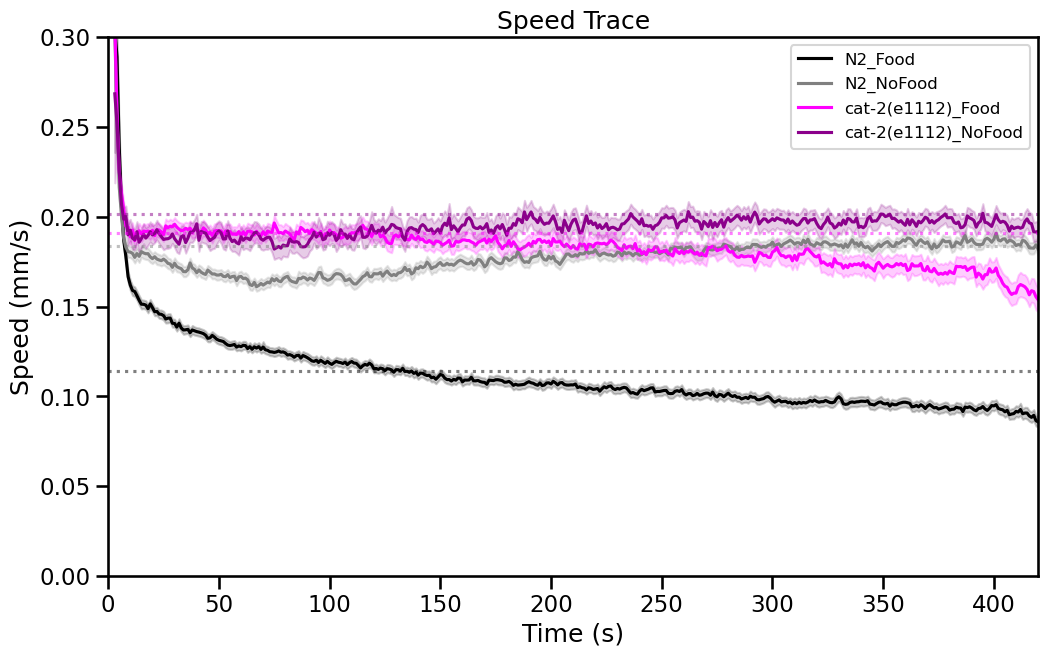

In [11]:
# Setting viewing range for your graph
top = 0.30
bottom = 0
left = 0
right = 420

# Set specifications for graph
sns.set_context("talk")
plt.figure(linewidth = 2.5)
plt.figure(figsize = (12, 7))
plt.gca().xaxis.grid(False)

# Specify data and colours to be used
ax = sns.lineplot(x = "time_bin",
                  y = "speed",
                  # data = TotalConcatenated,  # <----- uncomment and comment row below if using all data
                  data = TotalN2cat2,
                  hue = 'Strain',
                  palette = ['black',
                             'grey',
                             '#FF00FF',
                             '#8B008B',
                             # 'green',  # <----- uncomment additional colours if analyzing more strains (2 per strain)
                             # 'lightgreen',
                             # 'royalblue',
                             # 'lightblue',
                             # '#FFB5C5',
                             # '#CD6889'
                            ])

# Specify labels
plt.xlabel("Time (s)")
plt.ylabel("Speed (mm/s)")
plt.title("Speed Trace")

# Specify viewing range using variables at top of cell
plt.ylim(top = top)
plt.ylim(bottom = bottom)
plt.xlim(left= left)
plt.xlim(right = right)

# Add horizontal lines to visualize mean speed of each strain and condition (comment out if using more than N2 & CB1112)
# If keeping uncommented, may need to adjust indexing to calculate proper speeds
plt.axhline(y = TotalConcatenated_avg_speed['speed'][0], color = 'black', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][1], color = 'grey', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][2], color = '#FF00FF', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][3], color = '#8B008B', linestyle = ':', alpha = 0.5)

# # Add annotations to show mean speed of each strain and condition
# # Same caution as previous step regarding proper speeds
# ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][0], 3)}",
#             xy = (420, TotalConcatenated_avg_speed['speed'][0]),
#             xytext = (420, TotalConcatenated_avg_speed['speed'][0]),
#             color = 'black', size = 14)
# ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][1], 3)}",
#             xy = (420, TotalConcatenated_avg_speed['speed'][1] - 0.003),
#             xytext = (420, TotalConcatenated_avg_speed['speed'][1] - 0.003),
#             color = 'grey', size = 14)
# ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][4], 3)}",
#             xy = (420, TotalConcatenated_avg_speed['speed'][4] - 0.003),
#             xytext = (420, TotalConcatenated_avg_speed['speed'][4] - 0.003),
#             color = '#FF00FF', size = 14)
# ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][5], 3)}",
#             xy = (420, TotalConcatenated_avg_speed['speed'][5] - 0.005),
#             xytext = (420, TotalConcatenated_avg_speed['speed'][5] - 0.007),
#             color = '#8B008B', size = 14)

# Specify location for legend
ax.legend(loc = 'upper right', fontsize = '12'
          # , labels = ['N2 (Off Food)', 'N2 (On Food)', 'CB1112 (Off Food)', 'CB1112 (On Food)']
         )

# Save figure to current working directory
plt.savefig(f'Speed_Trace_{left}to{right}s.jpg', format = 'jpg', dpi = 450)

plt.show()

# 4 - Generate OffFood/OnFood comparison bar plots

## 4.1 - BSR bar plots (difference of differences and difference of percent change)

### 4.1.1 - First, take data only from the time in the experiment(s) you want to analyze, and find the average speed for each genotype and treatment

In [12]:
# print(TotalConcatenated.head(1))

start = 100  # <----- set the start time of the range
point = 350  # <----- set the end time of your range

# Take data between specified time points
chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Take mean of all measures for each worm
chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index = False).mean()

# Split `Strain` column into `Genotype` and `Treatment` columns
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)

# Select only the specified columns from previous result (others not important for BSR score)
worm_avg_speed = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', 'speed']]

# Take mean speed for each genotype and treatment (should result in 2 rows for each genotype - 1 for each condition)
avg_speed = worm_avg_speed.groupby(["Strain", 'Treatment', 'Genotype'], as_index = False).mean()
print(avg_speed)
# avg_speed.to_csv("avg_speed.csv")

                      Strain Treatment           Genotype     speed
0                    N2_Food      Food                 N2  0.115420
1                  N2_NoFood    NoFood                 N2  0.182548
2          cat-2(e1112)_Food      Food       cat-2(e1112)  0.192262
3        cat-2(e1112)_NoFood    NoFood       cat-2(e1112)  0.200817
4        catp-7(tm4438)_Food      Food     catp-7(tm4438)  0.060664
5      catp-7(tm4438)_NoFood    NoFood     catp-7(tm4438)  0.168907
6        catp-7(tm8556)_Food      Food     catp-7(tm8556)  0.067511
7      catp-7(tm8556)_NoFood    NoFood     catp-7(tm8556)  0.152036
8         cpr-4(ok3413)_Food      Food      cpr-4(ok3413)  0.066708
9       cpr-4(ok3413)_NoFood    NoFood      cpr-4(ok3413)  0.114848
10        cpr-5(ok2344)_Food      Food      cpr-5(ok2344)  0.075488
11      cpr-5(ok2344)_NoFood    NoFood      cpr-5(ok2344)  0.137827
12       cpr-6(tm12210)_Food      Food     cpr-6(tm12210)  0.097772
13     cpr-6(tm12210)_NoFood    NoFood     cpr-6

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\4139028439.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


### 4.1.2 - Then, calculate the difference in speed between conditions for each genotype (in mm/s), as well as the percent change in speed relative to OffFood speed for each genotype

In [13]:
# ABSOLUTE DIFFERENCE
# Drop `Strain` and `Treatment` columns, group by `Genotype` (without making index based on `Genotype`)
# Then, for each `Genotype`, subtract OnFood from OffFood speed
speed_diff = avg_speed.drop(columns = ["Strain", "Treatment"])
speed_diff = speed_diff.groupby("Genotype", as_index = False).diff(periods = -1).dropna()

# rename difference column to 'speed_diff'
speed_diff.columns = ['speed_diff']

print(speed_diff)

# PERCENT DIFFERENCE
avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)
speed_pct_diff = avg_speed['speed_pct_diff'].dropna()
avg_speed = avg_speed.drop(columns = ['speed_pct_diff'])

print(speed_pct_diff)

    speed_diff
0    -0.067129
2    -0.008555
4    -0.108242
6    -0.084525
8    -0.048140
10   -0.062339
12   -0.092348
14   -0.044468
16   -0.085043
18   -0.061157
20   -0.081213
22   -0.040451
24   -0.050307
26   -0.058395
28   -0.047999
30   -0.067928
32   -0.081459
34   -0.023649
36   -0.083453
0    -0.581605
2    -0.044495
4    -1.784286
6    -1.252005
8    -0.721657
10   -0.825819
12   -0.944515
14   -1.132741
16   -1.414673
18   -0.837489
20   -0.947525
22   -0.412551
24   -0.704743
26   -0.650692
28   -0.456347
30   -0.758980
32   -1.429474
34   -0.324030
36   -0.827246
Name: speed_pct_diff, dtype: float64


C:\Users\chris\AppData\Local\Temp\ipykernel_49340\1886152336.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)


### 4.1.3 - Combine the absolute difference and percent difference data

In [14]:
all_diff_measures = pd.concat([speed_diff, speed_pct_diff], axis = 1)
# all_diff_measures = all_diff_measures.rename(columns = {0: 'speed_pct_diff'})

# add `Genotype` labels back to speed difference measures so differences can be identified
all_diff_measures.insert(loc = 0, column = 'Genotype', value = avg_speed['Genotype'].unique())
all_diff_measures.reset_index(drop = True)

,Genotype,speed_diff,speed_pct_diff
0,N2,-0.067129,-0.581605
1,cat-2(e1112),-0.008555,-0.044495
2,catp-7(tm4438),-0.108242,-1.784286
3,catp-7(tm8556),-0.084525,-1.252005
4,cpr-4(ok3413),-0.048140,-0.721657
5,cpr-5(ok2344),-0.062339,-0.825819
6,cpr-6(tm12210),-0.092348,-0.944515
7,cpr-8(ok2956),-0.044468,-1.132741
8,djr-1.1(tm918),-0.085043,-1.414673
9,djr-1.2(tm817),-0.061157,-0.837489


### 4.1.4 - Calculate BSR score using both methods (difference of differences & difference of percent change)

In [15]:
# # find N2 speed differences
# print(all_diff_measures.iloc[0, 1])
# print(all_diff_measures.iloc[0, 2])

# calculate BSR score using difference of differences
all_diff_measures['Score_diff_of_diff'] = all_diff_measures['speed_diff'] - all_diff_measures.iloc[0,1]
all_diff_measures['Score_diff_of_pct_diff'] = all_diff_measures['speed_pct_diff'] - all_diff_measures.iloc[0,2]

print(all_diff_measures)

             Genotype  speed_diff  speed_pct_diff  Score_diff_of_diff  \
0                  N2   -0.067129       -0.581605            0.000000   
2        cat-2(e1112)   -0.008555       -0.044495            0.058574   
4      catp-7(tm4438)   -0.108242       -1.784286           -0.041114   
6      catp-7(tm8556)   -0.084525       -1.252005           -0.017396   
8       cpr-4(ok3413)   -0.048140       -0.721657            0.018988   
10      cpr-5(ok2344)   -0.062339       -0.825819            0.004790   
12     cpr-6(tm12210)   -0.092348       -0.944515           -0.025219   
14      cpr-8(ok2956)   -0.044468       -1.132741            0.022661   
16     djr-1.1(tm918)   -0.085043       -1.414673           -0.017915   
18     djr-1.2(tm817)   -0.061157       -0.837489            0.005972   
20     djr-1.2(tm951)   -0.081213       -0.947525           -0.014084   
22  exp-2(sa26ad1426)   -0.040451       -0.412551            0.026678   
24      kvs-5(tm6152)   -0.050307       -0.704743  

### 4.1.5 - Make separate dataframe for each method of BSR calculation, and sort by ascending BSR score

In [16]:
# DIFFERENCE OF DIFFERENCES
speed_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_diff"]).drop(columns = ['speed_pct_diff',
                                                                                               'Score_diff_of_pct_diff'])
speed_diff_sorted = speed_diff_sorted.reset_index(drop = True)
print(speed_diff_sorted)

# DIFFERENCE OF PERCENT CHANGE
speed_pct_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_pct_diff"]).drop(columns = ['speed_diff',
                                                                                                       'Score_diff_of_diff'])
speed_pct_diff_sorted = speed_pct_diff_sorted.reset_index(drop = True)
print(speed_pct_diff_sorted)

             Genotype  speed_diff  Score_diff_of_diff
0      catp-7(tm4438)   -0.108242           -0.041114
1      cpr-6(tm12210)   -0.092348           -0.025219
2      djr-1.1(tm918)   -0.085043           -0.017915
3      catp-7(tm8556)   -0.084525           -0.017396
4     sipa-1(tm11702)   -0.083453           -0.016325
5       ncs-4(tm4409)   -0.081459           -0.014330
6      djr-1.2(tm951)   -0.081213           -0.014084
7       mbr-1(tm1235)   -0.067928           -0.000800
8                  N2   -0.067129            0.000000
9       cpr-5(ok2344)   -0.062339            0.004790
10     djr-1.2(tm817)   -0.061157            0.005972
11       lfe-2(sy326)   -0.058395            0.008734
12      kvs-5(tm6152)   -0.050307            0.016822
13      cpr-4(ok3413)   -0.048140            0.018988
14      mbr-1(qa5901)   -0.047999            0.019130
15      cpr-8(ok2956)   -0.044468            0.022661
16  exp-2(sa26ad1426)   -0.040451            0.026678
17       rme-8(b1023)   -0.0

In [17]:
# NOT SURE WHAT THE USE OF THIS IS - BEN

# avg_speed["new"] = range(1, len(avg_speed) + 1)
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# print(avg_speed)
# # avg_speed.sort_values("new").drop('new', axis=1)

## 4.1.6 - Making the bar plot (difference of differences)

<Figure size 640x480 with 0 Axes>

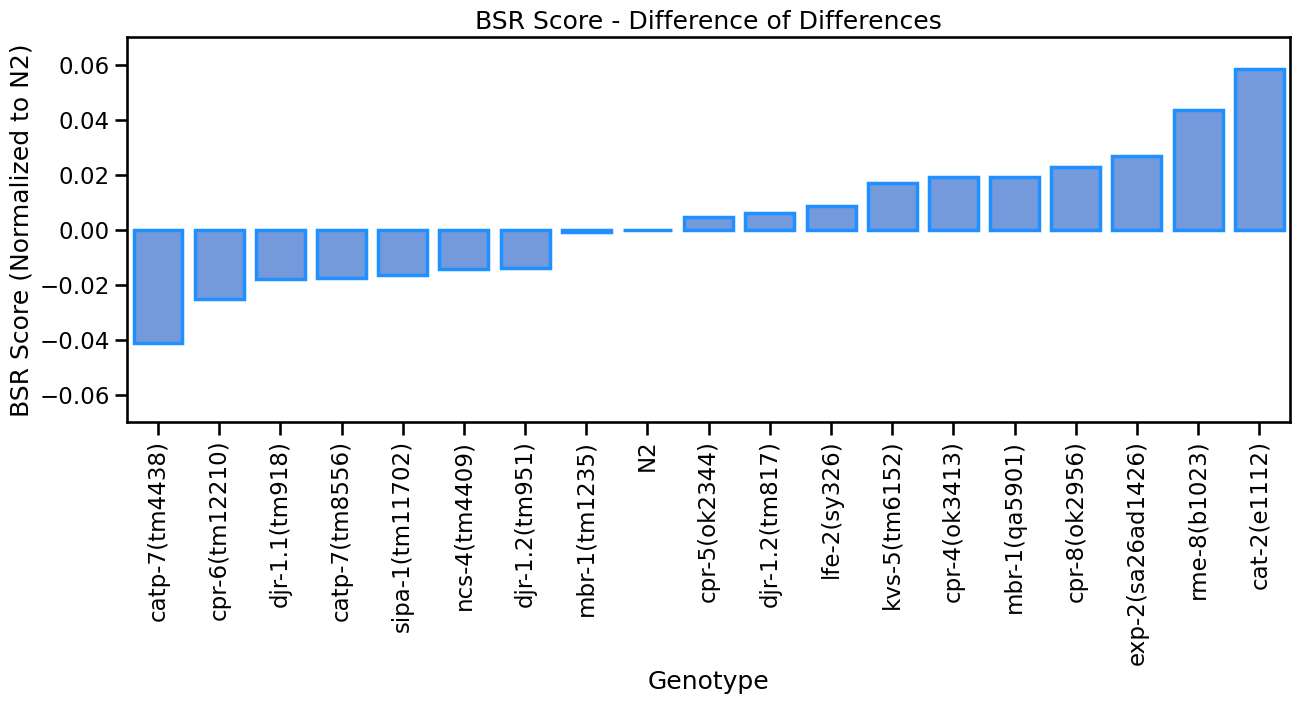

In [18]:
Title = "BSR Score - Difference of Differences"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_diff', 
             data = speed_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.ylim(top = 0.07)
plt.ylim(bottom = -0.07)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

## 4.1.7 - Making the bar plot (difference of percent change)

<Figure size 640x480 with 0 Axes>

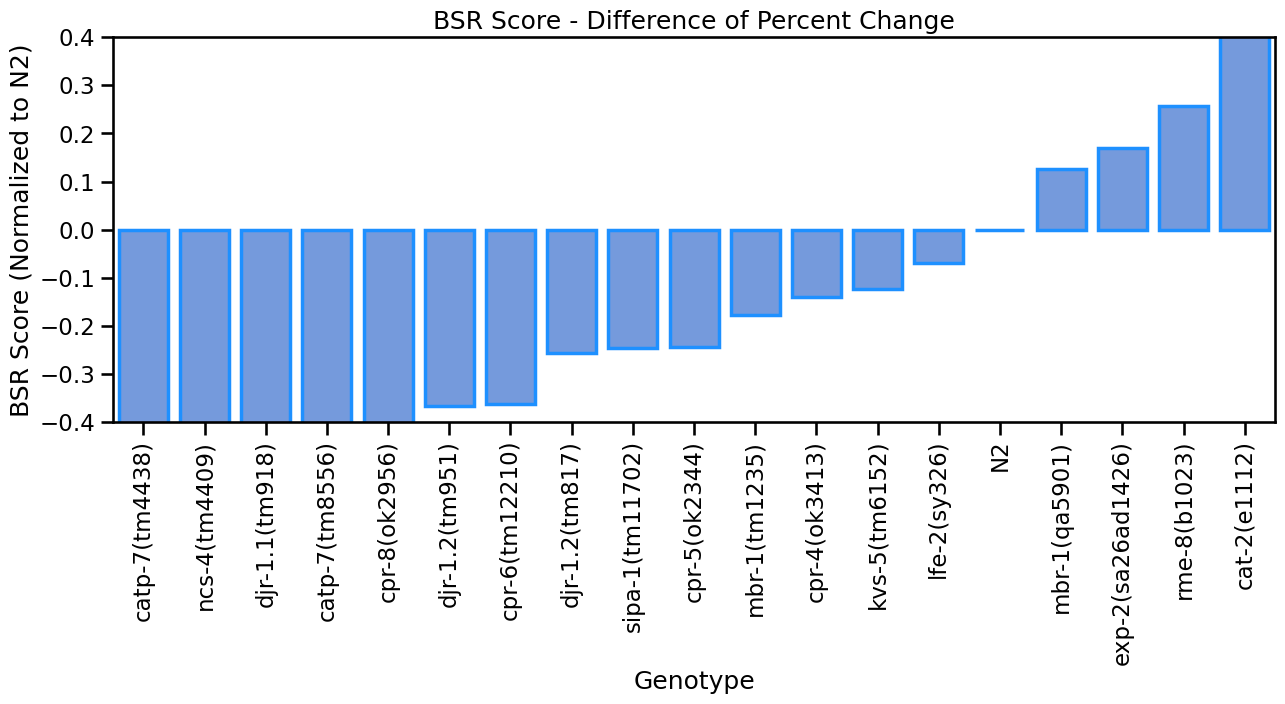

In [19]:
Title = "BSR Score - Difference of Percent Change"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_pct_diff', 
             data = speed_pct_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
plt.ylim(top = 0.4)
plt.ylim(bottom = -0.4)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

## 4.2 - Generic differences of differences script (for any behavioural phenotype)

Very little commentary here, as code is similar to that for BSR score apart from inputting behavioural phenotype of interest

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\530234562.py:9: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


             Genotype      bias     Score
18     djr-1.2(tm817) -0.181049 -0.368800
14      cpr-8(ok2956) -0.170895 -0.358646
32      ncs-4(tm4409) -0.139121 -0.326872
6      catp-7(tm8556) -0.089248 -0.276999
4      catp-7(tm4438) -0.066364 -0.254115
24      kvs-5(tm6152) -0.051179 -0.238930
16     djr-1.1(tm918) -0.028487 -0.216238
20     djr-1.2(tm951) -0.022480 -0.210231
8       cpr-4(ok3413)  0.015396 -0.172355
30      mbr-1(tm1235)  0.042382 -0.145369
28      mbr-1(qa5901)  0.049720 -0.138031
10      cpr-5(ok2344)  0.071248 -0.116503
36    sipa-1(tm11702)  0.092350 -0.095401
12     cpr-6(tm12210)  0.104650 -0.083101
22  exp-2(sa26ad1426)  0.166994 -0.020757
26       lfe-2(sy326)  0.168943 -0.018808
34       rme-8(b1023)  0.171515 -0.016236
2        cat-2(e1112)  0.183053 -0.004698
0                  N2  0.187751  0.000000


<Figure size 640x480 with 0 Axes>

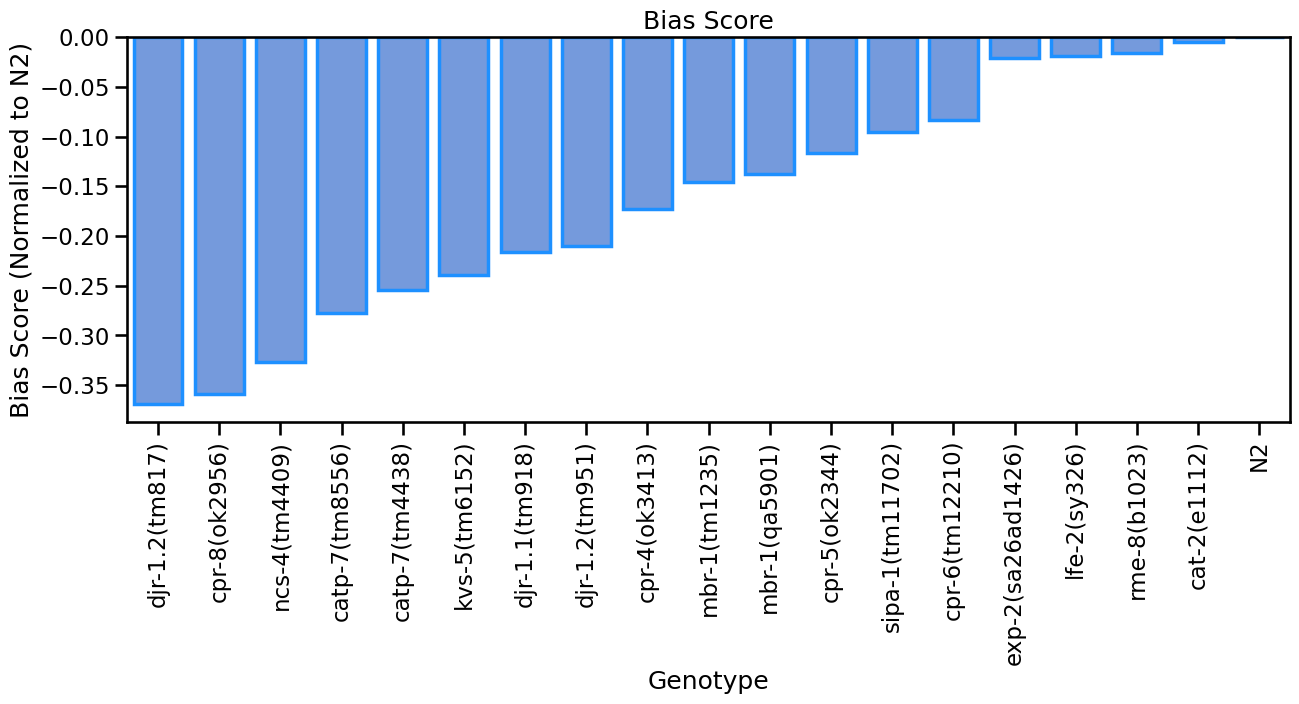

In [20]:
parameter = 'bias'  # <----- INPUT PHENOTYPE OF INTEREST HERE

start = 100 #<----- set the start time of the range
point = 400 #<------- set the end time of your range

chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
# print(avg_parameter)

# avg_parameter.to_csv("avg_parameter.csv")

parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index = False).diff(periods = -1).dropna()
parameter_diff.insert(loc = 0, column='Genotype', value = avg_parameter['Genotype'].unique())
parameter_diff.reset_index(drop = True)
# print(parameter_diff)
# print(parameter_diff.iloc[0,1])
parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[0,1]
parameter_diff = parameter_diff.sort_values(by = ["Score"])
print(parameter_diff)

#################

# print(parameter_diff.iloc[0,1])

#################

# AGAIN, NOT SURE WHAT THIS IS FOR - BEN
# avg_parameter["new"] = range(1,len(avg_parameter) + 1)
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# print(avg_parameter)
# # avg_parameter.sort_values("new").drop('new', axis=1)

#################

Title = f"{parameter.capitalize()} Score"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = "Genotype",
                 y = 'Score',
                 data = parameter_diff,  # <--------------- Input Here -------------
                 color = 'CornflowerBlue',
                 edgecolor = "DodgerBlue",
                 linewidth = 2.5,
                 # seed=5,
                 # ci = 95, # 'sd' for SD, '68' for SEM
                 # palette = ['grey',
                 #            'black'
                 #           ]
                )

plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel(f"{parameter.capitalize()} Score (Normalized to N2)")

# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')

plt.show()

# 5 - Phenotype Heatmap

## 5.1 - Calculate difference of differences scores for all behavioural phenotypes

In [21]:
behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
# print(all_strains)

def differences_of_differences(start, point, df):
    chunkeddata0 = df[df["time"] >= start]
    chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
    chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index=False).mean()
    chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
    all_scores = all_strains
    for parameter in behavioural_phenotypes:
        worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
        avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
        # print(avg_parameter)

        # avg_parameter.to_csv("avg_parameter.csv")

        parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index=False).diff(periods=-1).dropna()
        parameter_diff.insert(loc=0, column='Genotype', value = avg_parameter['Genotype'].unique())
        parameter_diff.reset_index(drop=True)
        # print(parameter_diff)
        # print(parameter_diff.iloc[0,1])
        parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[0,1]
        # parameter_diff = parameter_diff.sort_values(by = ["Score"])
        parameter_diff = parameter_diff.drop(columns = [parameter])
        parameter_diff = parameter_diff.rename(columns = {'Score':parameter})
        parameter_diff = parameter_diff.reset_index(drop = True)
        # print(parameter_diff)
        all_scores = all_scores.join(parameter_diff.iloc[:,1])
    all_scores = all_scores.set_index("Genotype")
    return(all_scores)

differences_of_differences(100, 400, TotalConcatenated)

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\2023198025.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


,speed,angularspeed,bias,curve,crab,kink
Genotype,,,,,,
N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cat-2(e1112),0.058734,4.208455,-0.004698,0.762732,0.006601,-0.408514
catp-7(tm4438),-0.039951,-0.207685,-0.254115,-2.684789,0.000431,-0.978839
catp-7(tm8556),-0.018677,1.951834,-0.276999,-0.477157,0.002696,4.319363
cpr-4(ok3413),0.018837,1.110828,-0.172355,0.233182,0.002916,2.209470
cpr-5(ok2344),0.006140,-0.492422,-0.116503,0.375669,0.000564,4.010101
cpr-6(tm12210),-0.024227,-0.061909,-0.083101,-0.707394,-0.000732,0.175075
cpr-8(ok2956),0.023631,2.953183,-0.358646,-1.164939,0.005199,-0.635355
djr-1.1(tm918),-0.016408,1.058817,-0.216238,-0.636912,0.001526,3.169285


### 5.1.1 - Use function defined above to store difference of difference dataframe in a new variable

In [22]:
PD_gene_behavioural_scores = differences_of_differences(100, 400, TotalConcatenated)
PD_gene_behavioural_scores = PD_gene_behavioural_scores.dropna().sort_index()
print(PD_gene_behavioural_scores)

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\2023198025.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


                      speed  angularspeed      bias     curve      crab  \
Genotype                                                                  
N2                 0.000000      0.000000  0.000000  0.000000  0.000000   
cat-2(e1112)       0.058734      4.208455 -0.004698  0.762732  0.006601   
catp-7(tm4438)    -0.039951     -0.207685 -0.254115 -2.684789  0.000431   
catp-7(tm8556)    -0.018677      1.951834 -0.276999 -0.477157  0.002696   
cpr-4(ok3413)      0.018837      1.110828 -0.172355  0.233182  0.002916   
cpr-5(ok2344)      0.006140     -0.492422 -0.116503  0.375669  0.000564   
cpr-6(tm12210)    -0.024227     -0.061909 -0.083101 -0.707394 -0.000732   
cpr-8(ok2956)      0.023631      2.953183 -0.358646 -1.164939  0.005199   
djr-1.1(tm918)    -0.016408      1.058817 -0.216238 -0.636912  0.001526   
djr-1.2(tm817)     0.005700      4.573997 -0.368800  1.545921  0.005747   
djr-1.2(tm951)    -0.014772      3.733808 -0.210231  0.564316  0.004268   
exp-2(sa26ad1426)  0.0288

### 5.1.2 - Standardize and normalize the difference of difference scores

In [23]:
PD_gene_behavioural_scores_standardize = (PD_gene_behavioural_scores - PD_gene_behavioural_scores.mean())/PD_gene_behavioural_scores.std()
print(PD_gene_behavioural_scores_standardize)

PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_standardize - PD_gene_behavioural_scores_standardize[PD_gene_behavioural_scores_standardize.index == 'N2'].squeeze()
PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_normalize.drop(index = 'N2')
print(PD_gene_behavioural_scores_normalize)

                      speed  angularspeed      bias     curve      crab  \
Genotype                                                                  
N2                -0.189908     -0.719860  1.321088  0.235501 -0.942872   
cat-2(e1112)       2.171310      1.533431  1.282575  0.765442  1.800182   
catp-7(tm4438)    -1.796013     -0.831058 -0.761952 -1.629869 -0.763858   
catp-7(tm8556)    -0.940758      0.325191 -0.949539 -0.096024  0.177481   
cpr-4(ok3413)      0.567377     -0.125100 -0.091746  0.397514  0.269046   
cpr-5(ok2344)      0.056917     -0.983512  0.366086  0.496513 -0.708287   
cpr-6(tm12210)    -1.163869     -0.753007  0.639893 -0.255991 -1.247020   
cpr-8(ok2956)      0.760096      0.861333 -1.618815 -0.573889  1.217680   
djr-1.1(tm918)    -0.849558     -0.152948 -0.451468 -0.207020 -0.308734   
djr-1.2(tm817)     0.039234      1.729149 -1.702053  1.309594  1.445328   
djr-1.2(tm951)    -0.783785      1.279295 -0.402227  0.627583  0.830957   
exp-2(sa26ad1426)  0.9706

## 5.2 - Calculate, standardize, and normalize t-scores for all baseline behavioural and morphological phenotypes

### 5.2.1 - Read in and tidy data (same data as used previously)

In [24]:
# PD_baseline = pd.read_csv('baseline_output.csv')
PD_baseline = pd.concat(dfs_to_append, ignore_index=True)
PD_baseline = PD_baseline.iloc[:, 1:]
PD_baseline = PD_baseline.drop(columns=["x", "y"])
PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', 1, expand=True)

print(PD_baseline.head())

C:\Users\chris\AppData\Local\Temp\ipykernel_49340\1017856684.py:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', 1, expand=True)


   time_bin  worm      time     speed  angularspeed  pathlength       kink  \
0       4.0   381  3.875333  0.199433      5.233333    0.030333  34.000000   
1       4.0   424  3.959000  0.215800      3.900000    0.017000  46.300000   
2       4.0  1230  3.646400  0.282660     10.040000    0.097600  34.520000   
3       4.0  1298  3.526000  0.365729     17.428571    0.170429  36.857143   
4       5.0   309  4.903500  0.265500     22.950000    0.035500  15.250000   

   bias      curve  dir      crab   length   midline     width  morphwidth  \
0   1.0  39.433333  0.0  0.015700  0.87930  0.977933  0.165600    0.097033   
1   1.0  35.300000  0.0  0.042900  0.81810  0.962800  0.272700    0.125000   
2   1.0  30.720000  0.0  0.036280  0.76248  1.025460  0.197100    0.094320   
3   1.0  34.785714  0.0  0.032114  0.74250  0.999971  0.211757    0.090957   
4   1.0  28.300000  0.0  0.025750  0.94095  1.039950  0.191700    0.087250   

       area   Strain Genotype Treatment  
0  0.091854  N2_Food

### 5.2.2 - Subset the final 100 seconds of the experiment

In [25]:
PD_baseline_last100 = PD_baseline[((PD_baseline.time <= 420) & (PD_baseline.time >= 320))]
PD_baseline_last100 = PD_baseline_last100.reset_index()
PD_baseline_last100 = PD_baseline_last100.dropna()
print(PD_baseline_last100)

           index  time_bin  worm        time     speed  angularspeed  \
0          79210     321.0     6  320.499818  0.043955      7.790909   
1          79211     321.0    10  320.499818  0.008827      0.572727   
2          79212     321.0    13  320.499818  0.084627      3.727273   
3          79213     321.0    14  320.453300  0.077550      1.030000   
4          79214     321.0    18  320.499818  0.017845      0.936364   
...          ...       ...   ...         ...       ...           ...   
1166407  4992493     420.0   808  419.491308  0.235246      6.692308   
1166408  4992494     420.0   814  419.491308  0.143369      6.384615   
1166409  4992495     420.0   815  419.491308  0.204108     14.407692   
1166410  4992496     420.0   820  419.434000  0.112090      1.260000   
1166411  4992497     420.0   838  419.524667  0.114283      8.033333   

         pathlength       kink      bias      curve       dir      crab  \
0          5.572364  95.127273  1.000000  31.590909  0.00618

### 5.2.3 - Generate list of all strains in data set

In [26]:
list = PD_baseline_last100["Genotype"].unique()
print(list)

['N2' 'cat-2(e1112)' 'cpr-4(ok3413)' 'cpr-5(ok2344)' 'lfe-2(sy326)'
 'sipa-1(tm11702)' 'djr-1.2(tm817)' 'djr-1.2(tm951)' 'cpr-6(tm12210)'
 'djr-1.1(tm918)' 'exp-2(sa26ad1426)' 'kvs-5(tm6152)' 'rme-8(b1023)'
 'cpr-8(ok2956)' 'ncs-4(tm4409)' 'catp-7(tm4438)' 'catp-7(tm8556)'
 'mbr-1(qa5901)' 'mbr-1(tm1235)']


### 5.2.4 - Separate OffFood and OnFood data for comparison of behaviour within conditions

In [27]:
# PD_baseline_last100_OffFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OffFood"].dropna().add_suffix('_OffFood')
# PD_baseline_last100_OffFood = PD_baseline_last100_OffFood.rename(columns = {'Genotype_OffFood': 'Genotype'})
PD_baseline_last100_OffFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "NoFood"].dropna().add_suffix('_OffFood')
PD_baseline_last100_OffFood = PD_baseline_last100_OffFood.rename(columns = {'Genotype_OffFood': 'Genotype'})


# PD_baseline_last100_OnFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OnFood"].dropna().add_suffix('_OnFood')
# PD_baseline_last100_OnFood = PD_baseline_last100_OnFood.rename(columns = {'Genotype_OnFood': 'Genotype'})
PD_baseline_last100_OnFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "Food"].dropna().add_suffix('_OnFood')
PD_baseline_last100_OnFood = PD_baseline_last100_OnFood.rename(columns = {'Genotype_OnFood': 'Genotype'})
print(PD_baseline_last100_OffFood)
print(PD_baseline_last100_OnFood)

         index_OffFood  time_bin_OffFood  worm_OffFood  time_OffFood  \
20792           158998             321.0             3    320.478556   
20793           158999             321.0             9    320.478556   
20794           159000             321.0            22    320.478556   
20795           159001             321.0            36    320.068500   
20796           159002             321.0            47    320.478556   
...                ...               ...           ...           ...   
1166407        4992493             420.0           808    419.491308   
1166408        4992494             420.0           814    419.491308   
1166409        4992495             420.0           815    419.491308   
1166410        4992496             420.0           820    419.434000   
1166411        4992497             420.0           838    419.524667   

         speed_OffFood  angularspeed_OffFood  pathlength_OffFood  \
20792         0.168122             13.988889           -2.489667   

### 5.2.5 - Generate empty dataframes for each measure of phenotype (scores will be added to these)

In [28]:
PD_gene_baseline_length_T = pd.DataFrame(columns = ["Genotype", "length"])
PD_gene_baseline_midline_T = pd.DataFrame(columns = ["Genotype", "midline"])
PD_gene_baseline_width_T = pd.DataFrame(columns = ["Genotype", "width"])
PD_gene_baseline_morphwidth_T = pd.DataFrame(columns = ["Genotype", "morphwidth"])
PD_gene_baseline_area_T = pd.DataFrame(columns = ["Genotype", "area"])

PD_gene_baseline_speed_T_OffFood = pd.DataFrame(columns = ["Genotype", "speed_OffFood"])
PD_gene_baseline_angularspeed_T_OffFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OffFood"])
PD_gene_baseline_bias_T_OffFood = pd.DataFrame(columns = ["Genotype", "bias_OffFood"])
PD_gene_baseline_curve_T_OffFood = pd.DataFrame(columns = ["Genotype", "curve_OffFood"])
PD_gene_baseline_crab_T_OffFood = pd.DataFrame(columns = ["Genotype", "crab_OffFood"])
PD_gene_baseline_kink_T_OffFood = pd.DataFrame(columns = ["Genotype", "kink_OffFood"])

PD_gene_baseline_speed_T_OnFood = pd.DataFrame(columns = ["Genotype", "speed_OnFood"])
PD_gene_baseline_angularspeed_T_OnFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OnFood"])
PD_gene_baseline_bias_T_OnFood = pd.DataFrame(columns = ["Genotype", "bias_OnFood"])
PD_gene_baseline_curve_T_OnFood = pd.DataFrame(columns = ["Genotype", "curve_OnFood"])
PD_gene_baseline_crab_T_OnFood = pd.DataFrame(columns = ["Genotype", "crab_OnFood"])
PD_gene_baseline_kink_T_OnFood = pd.DataFrame(columns = ["Genotype", "kink_OnFood"])

print(PD_gene_baseline_midline_T)

Empty DataFrame
Columns: [Genotype, midline]
Index: []


### 5.2.6 - Define t-test function

In [29]:
def TTest_Gene(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat = ttest_ind(DF_ref[DF_ref.Genotype == a][Type], DF_ref[DF_ref.Genotype == "N2"][Type], equal_var = False)[0]
        row = [a, Tstat]
        output.loc[len(output)] = row
    print(output)

### 5.2.7 - Use `TTest_Gene()` function to generate t-scores for each genotype, measure of phenotype, and condition

In [30]:
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "length", PD_baseline_last100, PD_gene_baseline_length_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "midline", PD_baseline_last100, PD_gene_baseline_midline_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "width", PD_baseline_last100, PD_gene_baseline_width_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "morphwidth", PD_baseline_last100, PD_gene_baseline_morphwidth_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "area", PD_baseline_last100, PD_gene_baseline_area_T)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_speed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_angularspeed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_bias_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_curve_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_crab_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_kink_T_OffFood)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_speed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_angularspeed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_bias_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_curve_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_crab_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_kink_T_OnFood)

             Genotype      length
0                  N2    0.000000
1        cat-2(e1112)  -21.547741
2       cpr-4(ok3413) -204.166203
3       cpr-5(ok2344) -313.414961
4        lfe-2(sy326) -187.755280
5     sipa-1(tm11702) -129.817342
6      djr-1.2(tm817)  -83.627981
7      djr-1.2(tm951)  -55.379139
8      cpr-6(tm12210)  -26.527644
9      djr-1.1(tm918) -233.036017
10  exp-2(sa26ad1426)  -83.466615
11      kvs-5(tm6152)  -81.690961
12       rme-8(b1023) -259.318406
13      cpr-8(ok2956) -213.549101
14      ncs-4(tm4409)   46.257014
15     catp-7(tm4438)  -16.847086
16     catp-7(tm8556)  -24.417510
17      mbr-1(qa5901)   71.835127
18      mbr-1(tm1235)  -14.897791
             Genotype     midline
0                  N2    0.000000
1        cat-2(e1112)    5.111004
2       cpr-4(ok3413) -279.749411
3       cpr-5(ok2344) -406.633737
4        lfe-2(sy326) -319.419564
5     sipa-1(tm11702) -218.489097
6      djr-1.2(tm817) -194.729307
7      djr-1.2(tm951) -223.868390
8      cpr-6(t

             Genotype  angularspeed_OnFood
0                  N2             0.000000
1        cat-2(e1112)           145.997357
2       cpr-4(ok3413)           -20.057894
3       cpr-5(ok2344)            15.199440
4        lfe-2(sy326)           -62.596773
5     sipa-1(tm11702)           -36.616452
6      djr-1.2(tm817)           -50.293588
7      djr-1.2(tm951)           -66.545697
8      cpr-6(tm12210)           -52.000147
9      djr-1.1(tm918)           -57.614271
10  exp-2(sa26ad1426)           -35.816824
11      kvs-5(tm6152)           -80.076852
12       rme-8(b1023)            24.268692
13      cpr-8(ok2956)           -45.520605
14      ncs-4(tm4409)          -145.804583
15     catp-7(tm4438)           -91.869054
16     catp-7(tm8556)           -62.069801
17      mbr-1(qa5901)             5.270193
18      mbr-1(tm1235)           -45.973193
             Genotype  bias_OnFood
0                  N2     0.000000
1        cat-2(e1112)    -8.253586
2       cpr-4(ok3413)   -75.366945


### 5.2.8 - Combine all dataframes generated in step 5.2.7

In [31]:
PD_gene_baseline_Tstats = PD_gene_baseline_length_T
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_midline_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_width_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_morphwidth_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_area_T.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OffFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OnFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.set_index("Genotype")
print(PD_gene_baseline_Tstats)

                       length     midline       width  morphwidth        area  \
Genotype                                                                        
N2                   0.000000    0.000000    0.000000    0.000000    0.000000   
cat-2(e1112)       -21.547741    5.111004   54.397997   44.929742   35.417416   
cpr-4(ok3413)     -204.166203 -279.749411  -66.166427 -113.244245 -327.701566   
cpr-5(ok2344)     -313.414961 -406.633737  -38.945663  -97.004302 -421.401782   
lfe-2(sy326)      -187.755280 -319.419564 -131.351233  -66.140192 -279.467494   
sipa-1(tm11702)   -129.817342 -218.489097  -80.292243  -26.956419 -158.657118   
djr-1.2(tm817)     -83.627981 -194.729307 -132.361644  -88.478264 -161.675264   
djr-1.2(tm951)     -55.379139 -223.868390 -185.449635 -122.844040 -225.603901   
cpr-6(tm12210)     -26.527644  -98.103232  -64.556983  -55.677540 -101.670077   
djr-1.1(tm918)    -233.036017 -394.573422 -194.626661 -221.524452 -446.723507   
exp-2(sa26ad1426)  -83.46661

### 5.2.9 - Standardize and normalize t-scores

In [32]:
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.dropna().sort_index()

PD_gene_baseline_Tstats_standardize = (PD_gene_baseline_Tstats - PD_gene_baseline_Tstats.mean())/PD_gene_baseline_Tstats.std()
print(PD_gene_baseline_Tstats_standardize)

PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_standardize - PD_gene_baseline_Tstats_standardize[PD_gene_baseline_Tstats_standardize.index == 'N2'].squeeze()
print('-'*45)
print(PD_gene_baseline_Tstats_normalize)
PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_normalize.drop(index = 'N2')
print('-'*45)
print(PD_gene_baseline_Tstats_normalize)


                     length   midline     width  morphwidth      area  \
Genotype                                                                
N2                 0.880056  1.154482  1.158758    1.098637  1.136124   
cat-2(e1112)       0.683317  1.189307  1.978989    1.741540  1.356571   
catp-7(tm4438)     0.726236  0.560675  0.114506   -0.215834  0.258878   
catp-7(tm8556)     0.657115  0.614166  0.040707   -0.714038  0.149326   
cpr-4(ok3413)     -0.984057 -0.751625  0.161079   -0.521782 -0.903576   
cpr-5(ok2344)     -1.981538 -1.616167  0.571523   -0.289404 -1.486791   
cpr-6(tm12210)     0.637849  0.486044  0.185347    0.301944  0.503303   
cpr-8(ok2956)     -1.069726 -1.289876 -1.222878   -1.427026 -1.542390   
djr-1.1(tm918)    -1.247649 -1.533993 -1.775886   -2.071170 -1.644400   
djr-1.2(tm817)     0.116502 -0.172330 -0.837034   -0.167404  0.129815   
djr-1.2(tm951)     0.374424 -0.370873 -1.637512   -0.659146 -0.268094   
exp-2(sa26ad1426)  0.117975  0.381907  0.795733    

## 5.3 - Generate phenotype heatmap with all measures

### 5.3.1A - Combine dataframe containing morphology and behaviour t-scores with dataframe containing difference of difference scores

In [33]:
full_heatmap_normalized = PD_gene_baseline_Tstats_normalize.join(PD_gene_behavioural_scores_normalize)

# Save the merged DataFrame as a CSV file to a specific directory
full_heatmap_normalized.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\phenotype_heatmap_normalized_dataframe.csv', index=True)

print(full_heatmap_normalized)

                     length   midline     width  morphwidth      area  \
Genotype                                                                
cat-2(e1112)      -0.196739  0.034824  0.820231    0.642903  0.220447   
catp-7(tm4438)    -0.153820 -0.593807 -1.044253   -1.314471 -0.877247   
catp-7(tm8556)    -0.222941 -0.540317 -1.118052   -1.812675 -0.986798   
cpr-4(ok3413)     -1.864113 -1.906107 -0.997679   -1.620419 -2.039700   
cpr-5(ok2344)     -2.861594 -2.770649 -0.587235   -1.388041 -2.622915   
cpr-6(tm12210)    -0.242207 -0.668439 -0.973411   -0.796693 -0.632821   
cpr-8(ok2956)     -1.949782 -2.444358 -2.381636   -2.525663 -2.678514   
djr-1.1(tm918)    -2.127705 -2.688475 -2.934645   -3.169808 -2.780524   
djr-1.2(tm817)    -0.763554 -1.326812 -1.995792   -1.266041 -1.006309   
djr-1.2(tm951)    -0.505632 -1.525355 -2.796270   -1.757783 -1.404218   
exp-2(sa26ad1426) -0.762081 -0.772575 -0.363025    0.182574 -0.452432   
kvs-5(tm6152)     -0.745869 -1.237666 -1.422290   -

### 5.3.1B - Combine dataframe containing morphology and behaviour raw scores (t-statistics) with dataframe containing difference of difference scores

In [34]:
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.dropna().sort_index()
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.drop(index = 'N2')
PD_gene_behavioural_scores = PD_gene_behavioural_scores.dropna().sort_index()

full_heatmap = PD_gene_baseline_Tstats.join(PD_gene_behavioural_scores)

# Save the merged DataFrame as a CSV file to a specific directory
full_heatmap.to_csv('C:\\Users\\chris\\Desktop\\Rankin_Lab\\valid_data\\phenotype_heatmap_dataframe.csv', index=True)

print(full_heatmap)

                       length     midline       width  morphwidth        area  \
Genotype                                                                        
cat-2(e1112)       -21.547741    5.111004   54.397997   44.929742   35.417416   
catp-7(tm4438)     -16.847086  -87.149910  -69.255199  -91.862810 -140.939845   
catp-7(tm8556)     -24.417510  -79.299435  -74.149574 -126.680176 -158.540513   
cpr-4(ok3413)     -204.166203 -279.749411  -66.166427 -113.244245 -327.701566   
cpr-5(ok2344)     -313.414961 -406.633737  -38.945663  -97.004302 -421.401782   
cpr-6(tm12210)     -26.527644  -98.103232  -64.556983  -55.677540 -101.670077   
cpr-8(ok2956)     -213.549101 -358.745623 -157.950927 -176.507893 -430.334355   
djr-1.1(tm918)    -233.036017 -394.573422 -194.626661 -221.524452 -446.723507   
djr-1.2(tm817)     -83.627981 -194.729307 -132.361644  -88.478264 -161.675264   
djr-1.2(tm951)     -55.379139 -223.868390 -185.449635 -122.844040 -225.603901   
exp-2(sa26ad1426)  -83.46661

### 5.3.2 - Produce and save heatmap

#### 5.3.2A - Heatmap of raw data

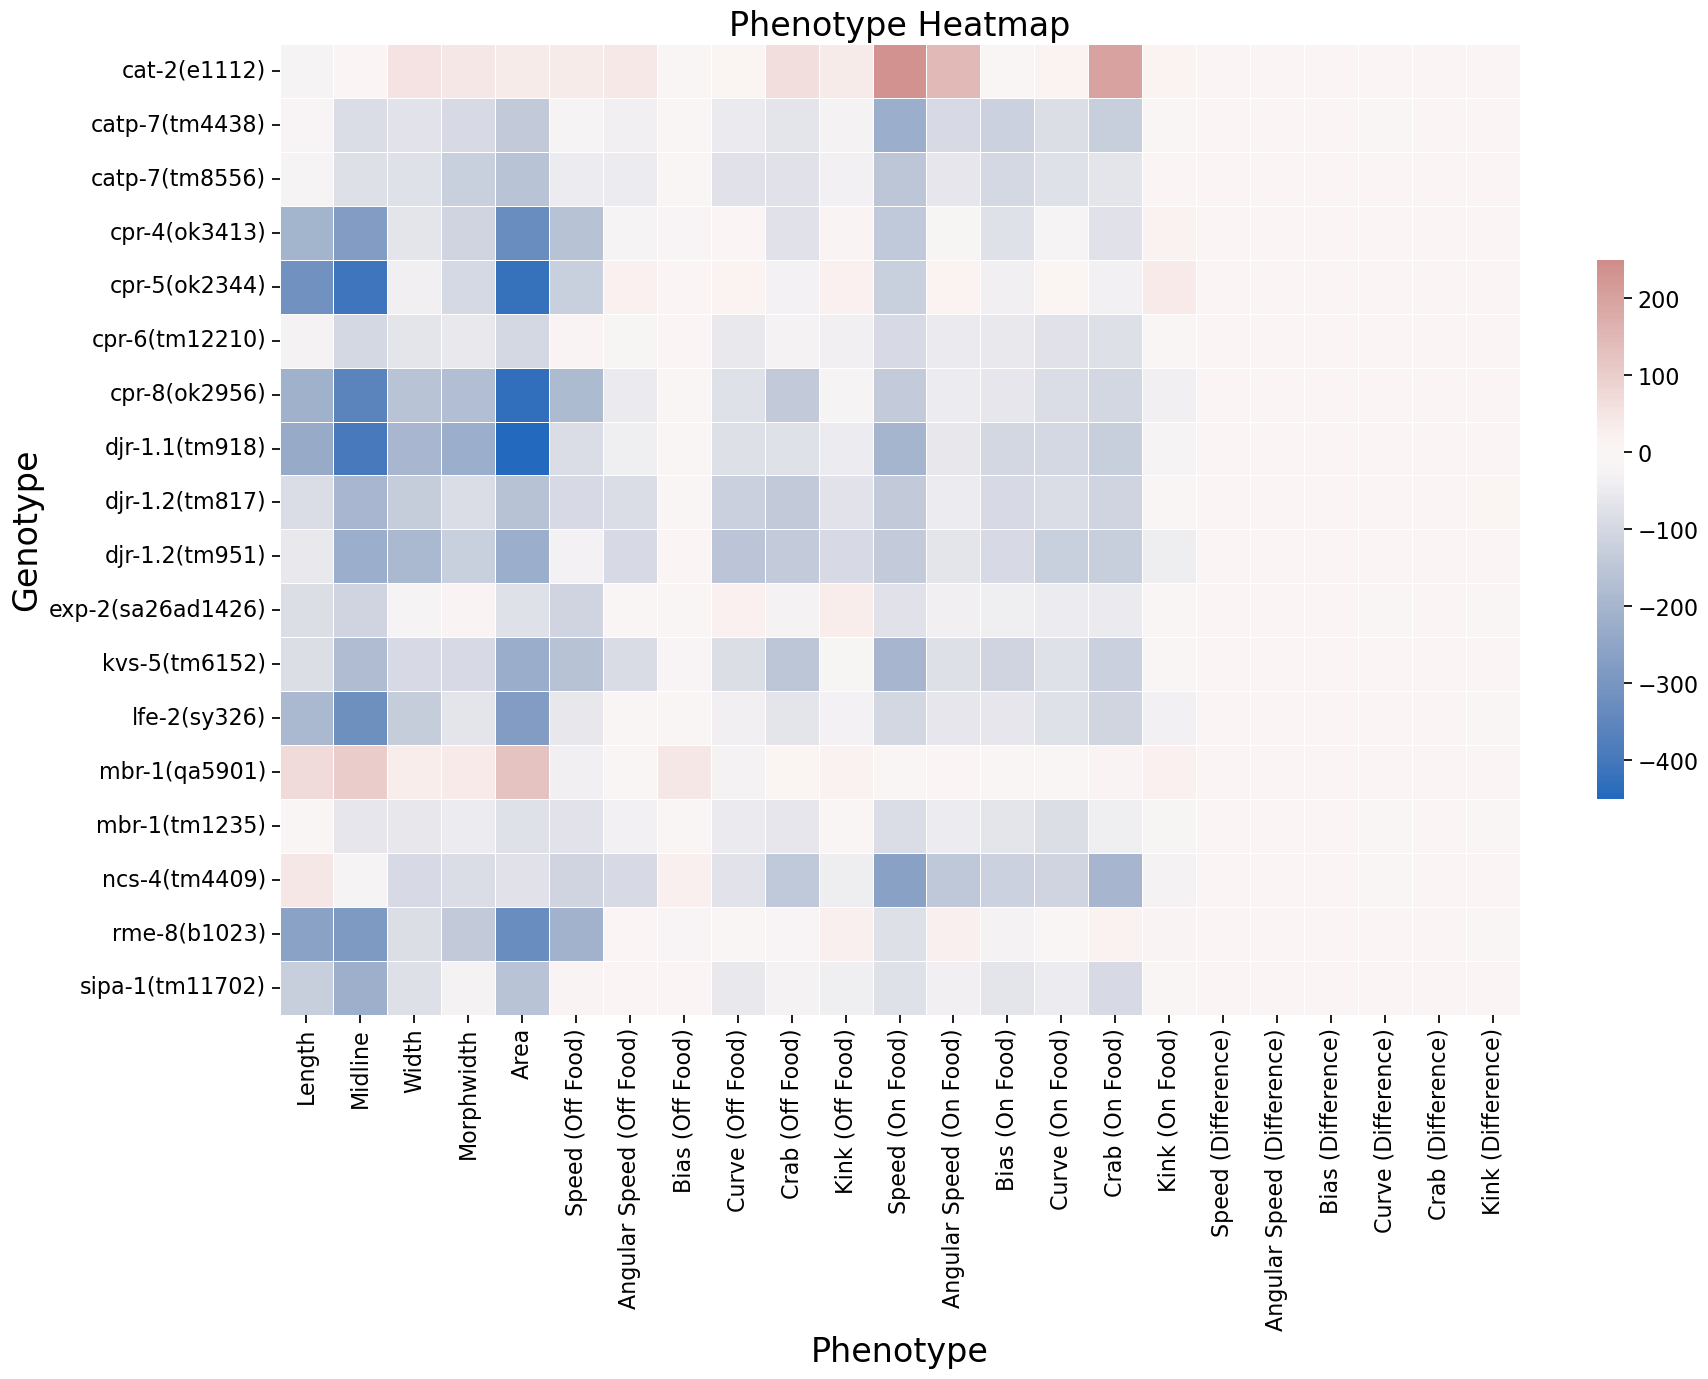

In [38]:
sns.set_context('notebook')
plt.figure(figsize = (20,14))
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16) 
ax = sns.heatmap(data = full_heatmap, 
                 annot = False, 
                 linewidth = 0.5, 
                 square = True, 
                 cmap = "vlag", 
                 center = 0, 
                 vmax = 250, # full_heatmap max = 236.046
                 vmin = -450, # full_heatmap min = -446.724
                 # xticklabels = 1,
                 xticklabels = ['Length', 'Midline', 'Width', 'Morphwidth', 'Area',
                                'Speed (Off Food)', 'Angular Speed (Off Food)', 'Bias (Off Food)',
                                'Curve (Off Food)', 'Crab (Off Food)', 'Kink (Off Food)',
                                'Speed (On Food)', 'Angular Speed (On Food)', 'Bias (On Food)',
                                'Curve (On Food)', 'Crab (On Food)', 'Kink (On Food)',
                                'Speed (Difference)', 'Angular Speed (Difference)', 'Bias (Difference)',
                                'Curve (Difference)', 'Crab (Difference)', 'Kink (Difference)'],
                 yticklabels = 1,
                 cbar_kws = {"shrink": .5,
                             # "label": "Normalized Behaviour Score"
                            })
ax.set_ylabel('Genotype', fontsize = 24)
ax.set_xlabel('Phenotype', fontsize = 24)
ax.set_title('Phenotype Heatmap', fontsize = 24)
# plt.savefig('BehaviourScore_GENE_normalized2_square.jpg', format='jpg', dpi=450, bbox_inches = "tight")
plt.savefig('Complete_GENE_heatmap_square.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

#### Heatmap of normalized t-score data

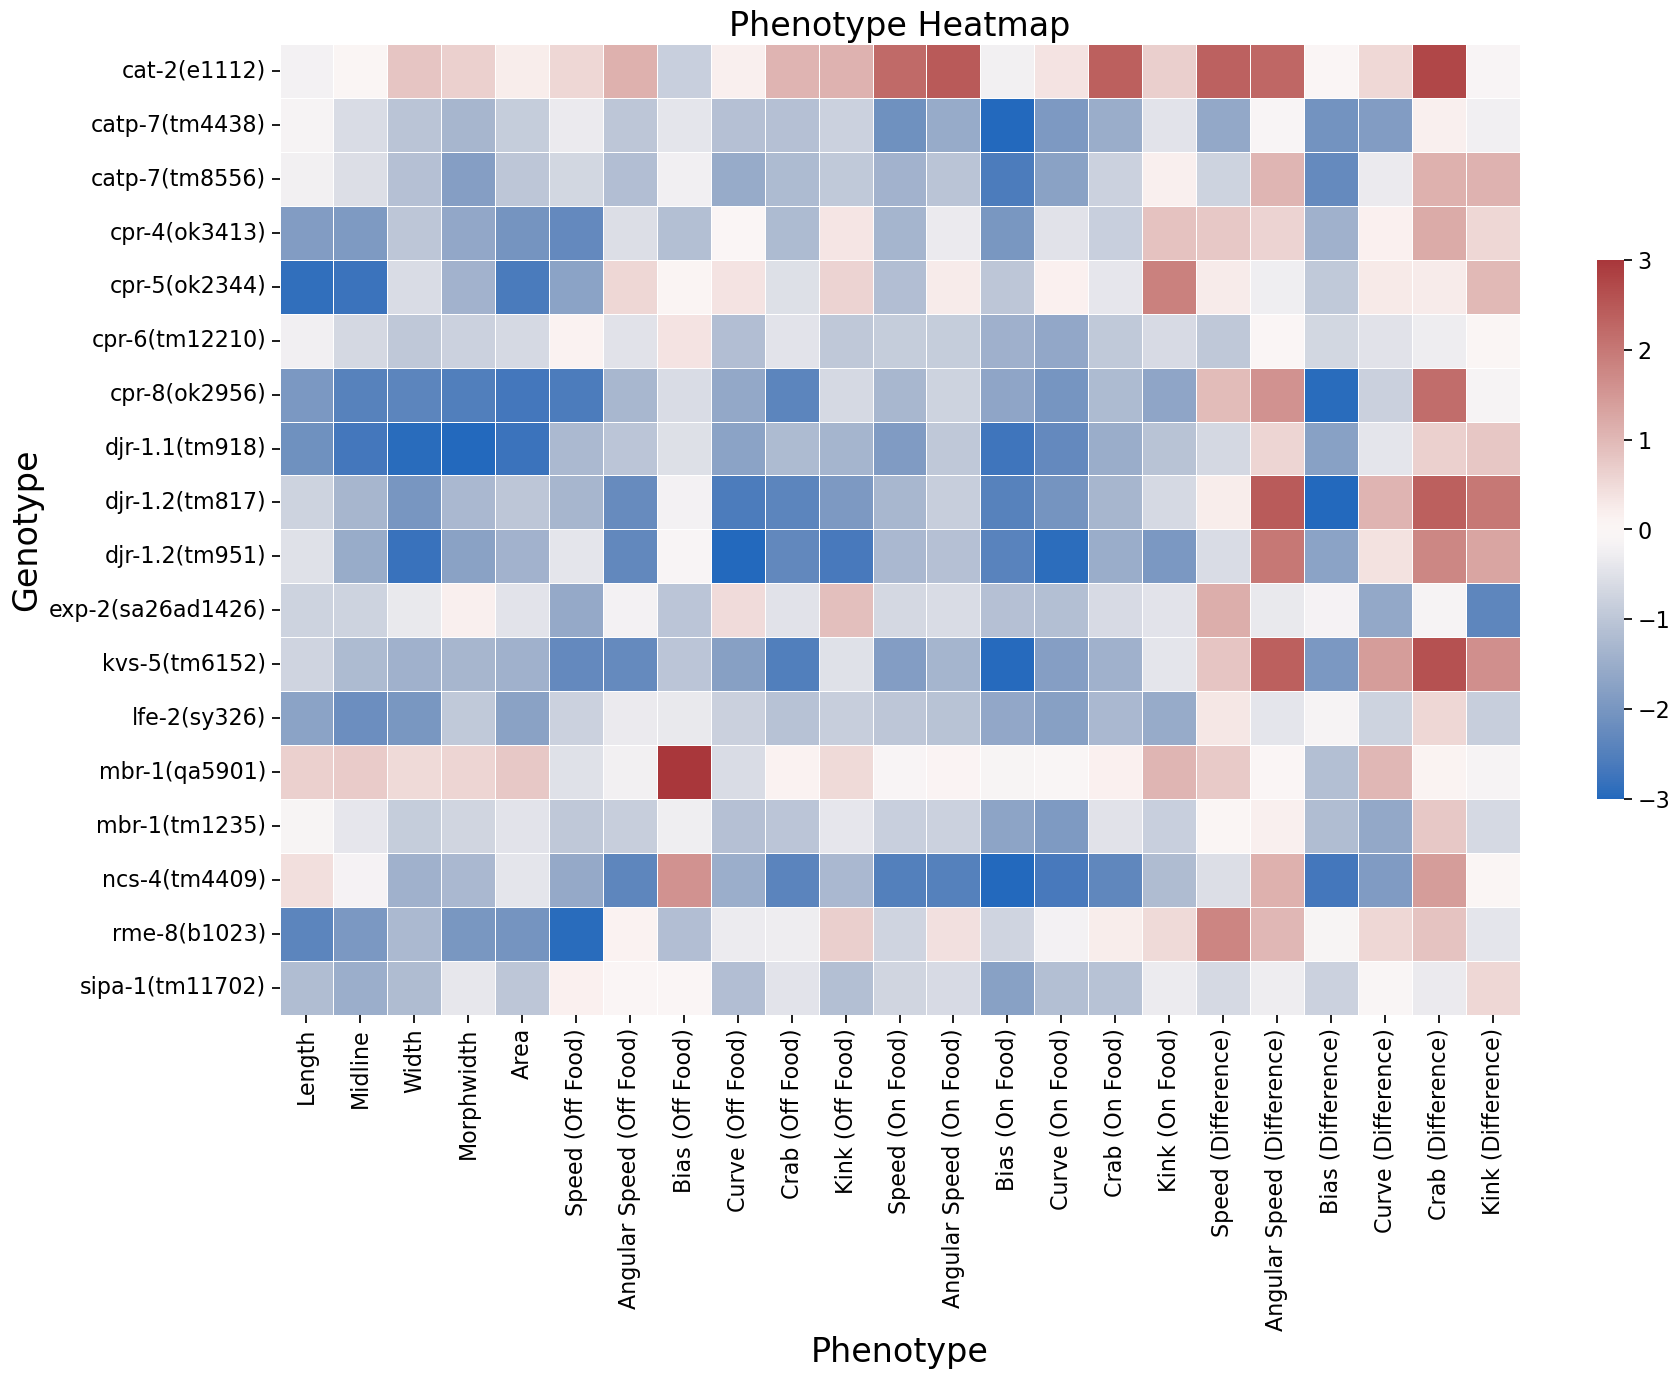

In [35]:
sns.set_context('notebook')
plt.figure(figsize = (20,14))
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16) 
ax = sns.heatmap(data = full_heatmap_normalized, 
                 annot = False, 
                 linewidth = 0.5, 
                 square = True, 
                 cmap = "vlag", 
                 center = 0, 
                 vmax = 3,
                 vmin = -3, 
                 # xticklabels = 1,
                 xticklabels = ['Length', 'Midline', 'Width', 'Morphwidth', 'Area',
                                'Speed (Off Food)', 'Angular Speed (Off Food)', 'Bias (Off Food)',
                                'Curve (Off Food)', 'Crab (Off Food)', 'Kink (Off Food)',
                                'Speed (On Food)', 'Angular Speed (On Food)', 'Bias (On Food)',
                                'Curve (On Food)', 'Crab (On Food)', 'Kink (On Food)',
                                'Speed (Difference)', 'Angular Speed (Difference)', 'Bias (Difference)',
                                'Curve (Difference)', 'Crab (Difference)', 'Kink (Difference)'],
                 yticklabels = 1,
                 cbar_kws = {"shrink": .5,
                             # "label": "Normalized Behaviour Score"
                            })
ax.set_ylabel('Genotype', fontsize = 24)
ax.set_xlabel('Phenotype', fontsize = 24)
ax.set_title('Phenotype Heatmap', fontsize = 24)
# plt.savefig('BehaviourScore_GENE_normalized2_square.jpg', format='jpg', dpi=450, bbox_inches = "tight")
plt.savefig('Complete_GENE_heatmap_normalized_square.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

# Everything below not intended for large scale analysis of many strains, and include bugs that would need to be fixed (commented out so notebook can be run start to finish)

# Graphing Bar Graphs

## Speed Barplots Comparison

In [ ]:
# # Valid Measurement inputs(change var)
# # 1:'speed', <---
# # 2: "x",
# # 3: "y",
# # 4: "angularspeed", <-----
# # 5: "pathlength",
# # 6: "kink",  <---
# # 7: "bias", <----
# # 8: "curve", <---
# # 9: "dir",<----
# # 10: "crab",<----
# # 11: "length",<---
# # 12: "midline",<----
# # 13: "width",<----
# # 14: "morphwidth",<----
# # 15: "area"<----

# start = 200
# point = 400
# var = "area"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
# chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
# chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split(' - ', 1, expand=True)

# Title = f"{var} - {start}-{point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 3))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata_mean, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
# #              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()

In [ ]:
# Test Cell
# chunkeddata_mean

In [ ]:
# Test Cell
# TotalConcatenated.describe()
# chunkeddata0
# chunkeddata

## Bias Barplots Comparison

In [ ]:
# point = 420
# var = "bias"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= 0]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Title = f"{var} - First {point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 5))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
#              ci = None,
#              palette = ['black',
#                         'grey'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# # plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()